In [1]:
%cd ..
%env DWAVE_API_TOKEN=DEV-b3a6691cb1873b651f8d6e32e16dafdde9f74281
!source source.me

import os
from PIL import Image
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

from models.autoencoders.gumboltCaloPRBM import GumBoltCaloPRBM
from models.samplers.pgbs import PGBS
import torch
from torch import nn
import matplotlib.pyplot as plt

from hydra import initialize, compose
from nbutils import *
from dwave.system import DWaveSampler

/home/blazerjia/beta_estimation/CaloQVAE
env: DWAVE_API_TOKEN=DEV-b3a6691cb1873b651f8d6e32e16dafdde9f74281


[15:24:12.868] INFO   CaloQVAE                                          Willkommen!
[15:24:12.870] INFO   CaloQVAE                                          Loading configuration.
2024-01-12 15:24:14,662 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[15:24:14.662] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def find_partition_key(idx, qubit_idxs):
    for key in qubit_idxs.keys():
        if idx in qubit_idxs[key]:
            return key
def energy_exp(p0_state, p1_state, p2_state, p3_state, weight_dict, bias_dict):
        """Energy expectation value under the 4-partite BM
        Overrides energy_exp in gumbolt.py

        :param p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :param p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :param p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :param p3_state (torch.Tensor) : (batch_size, n_nodes_p4)

        :return energy expectation value over the current batch
        """
        w_dict = weight_dict
        b_dict = bias_dict

        w_dict_cp = {}

        # Broadcast weight matrices (n_nodes_pa, n_nodes_pb) to
        # (batch_size, n_nodes_pa, n_nodes_pb)
        for key in w_dict.keys():
            w_dict_cp[key] = w_dict[key] + torch.zeros((p0_state.size(0),) +
                                                    w_dict[key].size(),
                                                    device=w_dict[key].device)

        # Prepare px_state_t for torch.bmm()
        # Change px_state.size() to (batch_size, 1, n_nodes_px)
        p0_state_t = p0_state.unsqueeze(2).permute(0, 2, 1)
        p1_state_t = p1_state.unsqueeze(2).permute(0, 2, 1)
        p2_state_t = p2_state.unsqueeze(2).permute(0, 2, 1)

        # Prepare py_state for torch.bmm()
        # Change py_state.size() to (batch_size, n_nodes_py, 1)
        p1_state_i = p1_state.unsqueeze(2)
        p2_state_i = p2_state.unsqueeze(2)
        p3_state_i = p3_state.unsqueeze(2)

        # Compute the energies for batch samples
        batch_energy = torch.matmul(p0_state, b_dict['0']) + \
            torch.matmul(p1_state, b_dict['1']) + \
            torch.matmul(p2_state, b_dict['2']) + \
            torch.matmul(p3_state, b_dict['3']) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['01'], p1_state_i)).reshape(-1) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['02'], p2_state_i)).reshape(-1) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['03'], p3_state_i)).reshape(-1) + \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['12'], p2_state_i)).reshape(-1) + \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['13'], p3_state_i)).reshape(-1) + \
            torch.bmm(p2_state_t,
                      torch.bmm(w_dict_cp['23'], p3_state_i)).reshape(-1)

        return batch_energy

In [3]:


def build_model(model_dir, _device = 'cpu'):
        model_dict = torch.load(model_dir)
        number_nodes_per_layer = len(model_dict['prior']['_weight_dict.01'])
        with initialize(config_path="../configs"):
                cfg = compose(config_name="config")
        cfg['model']['n_latent_nodes'] = number_nodes_per_layer
        model = GumBoltCaloPRBM(flat_input_size=[504],
                                train_ds_mean=0.,
                                activation_fct=torch.nn.ReLU(),
                                cfg=cfg)
        model.create_networks()
        for key in model.prior._weight_mask_dict.keys():
                model.prior._weight_mask_dict[key] = model_dict['prior'][f'_weight_mask_dict.{key}'].to(_device)
        for key in model.prior.weight_dict.keys():
                model.prior.weight_dict[key] = model_dict['prior'][f'_weight_dict.{key}'].to(_device)
        for key in model.prior.bias_dict.keys():
                model.prior.bias_dict[key] = model_dict['prior'][f'_bias_dict.{key}'].to(_device)
        model.prior._qubit_idx_dict, device = model.prior.gen_qubit_idx_dict()
        model.to(_device)
        return model


In [4]:
def create_ising(model, beta=1.0):
    prbm_weights = {}
    prbm_bias = {}
    for key in model.prior.weight_dict.keys():
        prbm_weights[key] = model.prior.weight_dict[key]
    for key in model.prior.bias_dict.keys():
        prbm_bias[key] = model.prior.bias_dict[key]
        
    prbm_edgelist = model.prior._pruned_edge_list

    idx_dict = model.prior._qubit_idx_dict

    qubit_idxs = idx_dict['0'] + idx_dict['1'] + idx_dict['2'] + idx_dict['3']

    idx_map = {}
    for key in idx_dict.keys():
        idx_map[key] = {idx:i for i, idx in enumerate(idx_dict[key])}


    dwave_weights = {}
    dwave_bias = {}

    for key in prbm_weights.keys():
        dwave_weights[key] = - prbm_weights[key]/4.
    for key in prbm_bias.keys():
        s = torch.zeros(prbm_bias[key].size(), device=prbm_bias[key].device)
        for i in range(4):
            if i > int(key):
                wKey = key + str(i)
                s = s - torch.sum(prbm_weights[wKey], dim=1)/4.
            elif i < int(key):
                wKey = str(i) + key
                s = s - torch.sum(prbm_weights[wKey], dim=0)/4.
        dwave_bias[key] = - prbm_bias[key]/2.0 + s
    dwave_weights_scaled = {}
    dwave_bias_scaled = {}
    for key in dwave_weights.keys():
        dwave_weights_scaled[key] = dwave_weights[key] / beta
    for key in dwave_bias.keys():
        dwave_bias_scaled[key] = dwave_bias[key] / beta

    dwave_weights_np = {}
    for key in dwave_weights_scaled.keys():
        dwave_weights_np[key] = dwave_weights_scaled[key].detach().cpu().numpy()
    biases = torch.cat([dwave_bias_scaled[key] for key in dwave_bias_scaled.keys()])

    h = {qubit_idx:bias for qubit_idx, bias in zip(qubit_idxs, biases)}
    J = {}
    for edge in prbm_edgelist:
        partition_edge_0 = find_partition_key(edge[0], idx_dict)
        partition_edge_1 = find_partition_key(edge[1], idx_dict)
        if int(partition_edge_0) < int(partition_edge_1):
            wKey = partition_edge_0 + partition_edge_1
            J[edge] = dwave_weights_np[wKey][idx_map[partition_edge_0][edge[0]]][idx_map[partition_edge_1][edge[1]]]
        elif int(partition_edge_0) > int(partition_edge_1):
            wKey = partition_edge_1 + partition_edge_0
            J[edge] = dwave_weights_np[wKey][idx_map[partition_edge_1][edge[1]]][idx_map[partition_edge_0][edge[0]]]
    return h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias

In [5]:
def plot_energies(rbm_energy_list, scaled_dwave_energies, beta,binwidth =3):
    data = np.concatenate((rbm_energy_list,scaled_dwave_energies), axis=0)
    bins =  np.arange(min(data), max(data) + binwidth, binwidth)
    plt.hist(rbm_energy_list, bins = bins, edgecolor='darkblue', linewidth=0.5, color = "white", label='RBM',density=True)
    plt.hist(scaled_dwave_energies, alpha=0.5, bins = bins, label='DWAVE',density=True)
    plt.legend(loc='upper right')
    plt.title(f'Energy Distribution beta = {beta:.3f}')

In [6]:
gpu = 3
qpu_sampler = DWaveSampler(solver={'topology__type': 'pegasus',  "chip_id":"Advantage_system6.3"})
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")

2024-01-12 15:24:19,533 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[15:24:19.533] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2024-01-12 15:24:19,625 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[15:24:19.625] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2024-01-12 15:24:21,619 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:24:21.619] INFO   dwave.cloud.client.base                

In [7]:
model_dir = '/fast_scratch/QVAE/models/GumBoltAtlasPRBMCNN_atlas_default_latest.pth'
model = build_model(model_dir)
model.to(device)

/tmp/ipykernel_688524/3807771702.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs"):
/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
2024-01-12 15:24:28,548 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[15:24:28.548] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v

40105 14325


2024-01-12 15:24:32,080 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[15:24:32.080] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2024-01-12 15:24:32,134 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[15:24:32.134] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers


Initializing NetworkV3


2024-01-12 15:24:34,010 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:24:34.010] INFO   dwave.cloud.client.base                           Received solver data for 6 solver(s).
2024-01-12 15:24:34,057 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[15:24:34.057] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2024-01-12 15:24:34,072 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage2_prototype1.1')
[15:24:34.072] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage2_prototype1.1')
2024-01-12 15:24:34,117 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system6.3')
[15:24:34.117] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system6.3')


('training', True)
('_parameters', OrderedDict())
('_buffers', OrderedDict())
('_non_persistent_buffers_set', set())
('_backward_pre_hooks', OrderedDict())
('_backward_hooks', OrderedDict())
('_is_full_backward_hook', None)
('_forward_hooks', OrderedDict())
('_forward_pre_hooks', OrderedDict())
('_state_dict_hooks', OrderedDict())
('_load_state_dict_pre_hooks', OrderedDict())
('_load_state_dict_post_hooks', OrderedDict())
('_modules', OrderedDict([('_activation_fct', ReLU()), ('_bce_loss', BCEWithLogitsLoss()), ('_energy_activation_fct', ReLU()), ('_hit_activation_fct', Sigmoid()), ('_output_loss', MSELoss()), ('_hit_loss', BCEWithLogitsLoss()), ('_hit_smoothing_dist_mod', GumbelMod(
  (activation_fct): Sigmoid()
)), ('encoder', HierarchicalEncoderV2(
  (_layers): ModuleList()
  (activation_fct): ReLU()
  (_networks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=505, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=350, bi

In [8]:
def beta_training_1(model, beta_init = 10.0, num_of_batches = 8, batch_size = 128, gibbs_steps = 3000, lr = 0.01):
    beta = beta_init
    number_of_epochs = 0 
    error_list = []
    prbm_sampler = PGBS(model.prior, batch_size, gibbs_steps)
    h, J, qubit_idxs, idx_dict, ising_weights, ising_bias = create_ising(model, beta=1)
    rbm_energies_list = np.array([])
    for batch in range(num_of_batches):
        p0_state, p1_state, p2_state, p3_state = prbm_sampler.block_gibbs_sampling()
        p0_ising = p0_state * 2 - 1
        p1_ising = p1_state * 2 - 1
        p2_ising = p2_state * 2 - 1
        p3_ising = p3_state * 2 - 1
        rbm_energies = energy_exp(p0_ising, p1_ising, p2_ising, p3_ising, ising_weights, ising_bias)
        rbm_energies = rbm_energies.detach().cpu().numpy()
        rbm_energies_list = np.concatenate([rbm_energies_list, rbm_energies])
    mean_rbm_energy = np.mean(rbm_energies_list)
    error_limit = 0
    energy_loss = error_limit
    dwave_energies = 0
    while energy_loss >= error_limit:
        h, J, qubit_idxs, idx_dict = create_ising(model, beta = beta)[:4]
        response = qpu_sampler.sample_ising(h, J, num_reads=128, auto_scale=False)
        dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
        nonpl = len(idx_dict['0'])
        dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
        dwave_1_t = torch.tensor(dwave_1).to(device).float()
        dwave_2_t = torch.tensor(dwave_2).to(device).float()
        dwave_3_t = torch.tensor(dwave_3).to(device).float()
        dwave_4_t = torch.tensor(dwave_4).to(device).float()
        dwave_energies = energy_exp(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, ising_weights, ising_bias)
        dwave_energies = dwave_energies.detach().cpu().numpy()
        error_limit = 2.0 * np.std(rbm_energies) * np.std(dwave_energies) / (np.sqrt(batch_size) * (np.std(rbm_energies) + np.std(dwave_energies)))
        mean_dwave_energy = np.mean(dwave_energies)
        energy_loss = abs(mean_dwave_energy - mean_rbm_energy)
        error_list.append(energy_loss)
        number_of_epochs += 1
        print('Number of epoch:', number_of_epochs, '    Beta:', beta, '    Error Limit:', error_limit, '    Energy Loss:', energy_loss)
        if number_of_epochs > 29: break
        beta = max(beta - lr * (mean_dwave_energy - mean_rbm_energy), 2.0)
    print('Method 1:    The trained beta is:', beta)
    method_1_epoches = number_of_epochs
    print('Method 1:    The number of epoch of the beta training is:', method_1_epoches)
    return beta, error_list, rbm_energies, dwave_energies, method_1_epoches


def adaptive_linear_training(model, beta_init = 20.0, num_of_batches = 8, batch_size = 128, gibbs_steps = 3000):
    beta = beta_init
    lr = 0.01
    number_of_epochs = 0 
    error_list = []
    prbm_sampler = PGBS(model.prior, batch_size, gibbs_steps)
    h, J, qubit_idxs, idx_dict, ising_weights, ising_bias = create_ising(model, beta=1)
    rbm_energies_list = np.array([])
    for batch in range(num_of_batches):
        p0_state, p1_state, p2_state, p3_state = prbm_sampler.block_gibbs_sampling()
        p0_ising = p0_state * 2 - 1
        p1_ising = p1_state * 2 - 1
        p2_ising = p2_state * 2 - 1
        p3_ising = p3_state * 2 - 1
        rbm_energies = energy_exp(p0_ising, p1_ising, p2_ising, p3_ising, ising_weights, ising_bias)
        rbm_energies = rbm_energies.detach().cpu().numpy()
        rbm_energies_list = np.concatenate([rbm_energies_list, rbm_energies])
    mean_rbm_energy = np.mean(rbm_energies_list)
    error_limit = 0
    energy_loss = error_limit
    dwave_energies = 0
    while energy_loss >= error_limit:
        h, J, qubit_idxs, idx_dict = create_ising(model, beta = beta)[:4]
        response = qpu_sampler.sample_ising(h, J, num_reads=128, auto_scale=False)
        dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
        nonpl = len(idx_dict['0'])
        dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
        dwave_1_t = torch.tensor(dwave_1).to(device).float()
        dwave_2_t = torch.tensor(dwave_2).to(device).float()
        dwave_3_t = torch.tensor(dwave_3).to(device).float()
        dwave_4_t = torch.tensor(dwave_4).to(device).float()
        dwave_energies = energy_exp(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, ising_weights, ising_bias)
        dwave_energies = dwave_energies.detach().cpu().numpy()
        error_limit = 2.0 * np.std(rbm_energies) * np.std(dwave_energies) / (np.sqrt(batch_size) * (np.std(rbm_energies) + np.std(dwave_energies)))
        mean_dwave_energy = np.mean(dwave_energies)
        energy_loss = abs(mean_dwave_energy - mean_rbm_energy)
        error_list.append(energy_loss)
        number_of_epochs += 1
        print('Number of epoch:', number_of_epochs, '    Beta:', beta, '    Error Limit:', error_limit, '    Energy Loss:', energy_loss)
        if number_of_epochs > 29: break
        lr = 2 * beta / np.var(dwave_energies)
        print('Current Learning rate:', lr)
        beta = max(beta - lr * (mean_dwave_energy - mean_rbm_energy), 2.0)
    print('Method 1:    The trained beta is:', beta)
    method_1_epoches = number_of_epochs
    print('Method 1:    The number of epoch of the beta training is:', method_1_epoches)
    return beta, error_list, rbm_energies, dwave_energies, method_1_epoches

def adaptive_scale_training(model, beta_init = 10.0, num_of_batches = 8, batch_size = 128, gibbs_steps = 3000):
    beta = beta_init
    number_of_epochs = 0 
    error_list = []
    prbm_sampler = PGBS(model.prior, batch_size, gibbs_steps)
    h, J, qubit_idxs, idx_dict, ising_weights, ising_bias = create_ising(model, beta=1)
    rbm_energies_list = np.array([])
    for batch in range(num_of_batches):
        p0_state, p1_state, p2_state, p3_state = prbm_sampler.block_gibbs_sampling()
        p0_ising = p0_state * 2 - 1
        p1_ising = p1_state * 2 - 1
        p2_ising = p2_state * 2 - 1
        p3_ising = p3_state * 2 - 1
        rbm_energies = energy_exp(p0_ising, p1_ising, p2_ising, p3_ising, ising_weights, ising_bias)
        rbm_energies = rbm_energies.detach().cpu().numpy()
        rbm_energies_list = np.concatenate([rbm_energies_list, rbm_energies])
    mean_rbm_energy = np.mean(rbm_energies_list)
    error_limit = 0
    energy_loss = error_limit
    dwave_energies = 0
    while energy_loss >= error_limit:
        h, J, qubit_idxs, idx_dict = create_ising(model, beta = beta)[:4]
        response = qpu_sampler.sample_ising(h, J, num_reads=128, auto_scale=False)
        dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
        nonpl = len(idx_dict['0'])
        dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
        dwave_1_t = torch.tensor(dwave_1).to(device).float()
        dwave_2_t = torch.tensor(dwave_2).to(device).float()
        dwave_3_t = torch.tensor(dwave_3).to(device).float()
        dwave_4_t = torch.tensor(dwave_4).to(device).float()
        dwave_energies = energy_exp(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, ising_weights, ising_bias)
        dwave_energies = dwave_energies.detach().cpu().numpy()
        error_limit = 2.0 * np.std(rbm_energies) * np.std(dwave_energies) / (np.sqrt(batch_size) * (np.std(rbm_energies) + np.std(dwave_energies)))
        mean_dwave_energy = np.mean(dwave_energies)
        energy_loss = abs(mean_dwave_energy - mean_rbm_energy)
        error_list.append(energy_loss)
        number_of_epochs += 1
        print('Number of epoch:', number_of_epochs, '    Beta:', beta, '    Error Limit:', error_limit, '    Energy Loss:', energy_loss)
        if number_of_epochs > 29: break
        training_order = max(1, np.floor( - 2 * mean_dwave_energy/np.var(dwave_energies)))
        print('Current training order:', training_order )
        beta = max(beta * (mean_dwave_energy / mean_rbm_energy)**training_order, 2.0)
    print('Method S:    The trained beta is:', beta)
    method_s_epoches = number_of_epochs
    print('Method S:    The number of epoch of the beta training is:', method_s_epoches)
    return beta, error_list, rbm_energies, dwave_energies, method_s_epoches

In [9]:
def collect_training_data(model, beta_init = 20):
    method_1_epoches_list = []
    for i in range(10):
        beta, error_list, rbm_energies, dwave_energies, method_1_epoches = adaptive_scale_training(model, beta_init = beta_init)
        method_1_epoches_list.append(method_1_epoches)
    print('Training Epoches List:', method_1_epoches_list)
    return method_1_epoches_list

In [17]:
method_1_epoches_list = collect_training_data(model, beta_init = 20)

Number of epoch: 1     Beta: 20     Error Limit: 1.7165830162723885     Energy Loss: 3187.76415348053
Current Learning rate: 0.0024800884500294873
Number of epoch: 2     Beta: 12.094062941534911     Error Limit: 1.6952324704473651     Energy Loss: 1742.0065851211548
Current Learning rate: 0.00203446249083649
Number of epoch: 3     Beta: 8.550015885315759     Error Limit: 1.6336450566697933     Energy Loss: 949.6061944961548
Current Learning rate: 0.002935609069873595
Number of epoch: 4     Beta: 5.762343327944698     Error Limit: 1.5251023926735685     Energy Loss: 308.3933038711548
Current Learning rate: 0.004987849936356118
Number of epoch: 5     Beta: 4.224123806858305     Error Limit: 1.3414337655631488     Energy Loss: 96.20287418365479
Current Learning rate: 0.011362943075820435
Number of epoch: 6     Beta: 3.1309760237791204     Error Limit: 1.0651858159182934     Energy Loss: 12.739983558654785
Current Learning rate: 0.03143412302186575
Number of epoch: 7     Beta: 2.7305058132

In [21]:
method_1_epoches_list_45al = collect_training_data(model, beta_init = 4.5)

Number of epoch: 1     Beta: 4.5     Error Limit: 1.4063656864083427     Energy Loss: 111.29090166091919
Current Learning rate: 0.011770212651829166
Number of epoch: 2     Beta: 3.1900824212371734     Error Limit: 1.036070904132821     Energy Loss: 5.5868000984191895
Current Learning rate: 0.04195147559566289
Number of epoch: 3     Beta: 2.9557079132504938     Error Limit: 0.9417996612402355     Energy Loss: 5.6461100578308105
Current Learning rate: 0.05696686572993996
Number of epoch: 4     Beta: 3.277349106811405     Error Limit: 1.084766791696697     Energy Loss: 4.3714680671691895
Current Learning rate: 0.03534160297101584
Number of epoch: 5     Beta: 3.1228544179810376     Error Limit: 1.0924550131907482     Energy Loss: 1.4844889640808105
Current Learning rate: 0.03263187254060286
Number of epoch: 6     Beta: 3.171296072644854     Error Limit: 1.021134118271153     Energy Loss: 3.2779459953308105
Current Learning rate: 0.044311161644176394
Number of epoch: 7     Beta: 3.316545667

In [10]:
method_1_epoches_list_20asc = collect_training_data(model, beta_init = 20)

Number of epoch: 1     Beta: 20     Error Limit: 1.7068448532423082     Energy Loss: 2944.560260295868
Current training order: 1
Number of epoch: 2     Beta: 11.604483741789524     Error Limit: 1.667884468119851     Energy Loss: 1373.866168498993
Current training order: 1
Number of epoch: 3     Beta: 9.331652354238301     Error Limit: 1.6060434334687064     Energy Loss: 918.4232974052429
Current training order: 2.0
Number of epoch: 4     Beta: 7.048031890304074     Error Limit: 1.5248559723297317     Energy Loss: 417.7040591239929
Current training order: 5.0
Number of epoch: 5     Beta: 5.185032863076046     Error Limit: 1.4144356029012342     Energy Loss: 148.30366849899292
Current training order: 11.0
Number of epoch: 6     Beta: 4.0989015819899945     Error Limit: 1.147362037745347     Energy Loss: 44.48189115524292
Current training order: 46.0
Number of epoch: 7     Beta: 3.0590032712308632     Error Limit: 1.052235542704765     Energy Loss: 1.65580415725708
Current training order:

In [13]:
method_1_epoches_list_45asc = collect_training_data(model, beta_init = 4.5)

Number of epoch: 1     Beta: 4.5     Error Limit: 1.1591130742424214     Energy Loss: 48.685256004333496
Current training order: 38.0
Number of epoch: 2     Beta: 3.453612711336475     Error Limit: 1.0021104460470645     Energy Loss: 0.4802713394165039
Current training order: 82.0
Method S:    The trained beta is: 3.4730559699329606
Method S:    The number of epoch of the beta training is: 2
Number of epoch: 1     Beta: 4.5     Error Limit: 1.0554268500660922     Energy Loss: 13.392736434936523
Current training order: 79.0
Number of epoch: 2     Beta: 3.8694428651977146     Error Limit: 1.002547473584493     Energy Loss: 2.4226932525634766
Current training order: 99.0
Number of epoch: 3     Beta: 4.004004610380346     Error Limit: 1.0663150401126111     Energy Loss: 6.216466903686523
Current training order: 75.0
Number of epoch: 4     Beta: 3.7464295684937774     Error Limit: 1.2114219733295841     Energy Loss: 39.01138877868652
Current training order: 40.0
Number of epoch: 5     Beta:

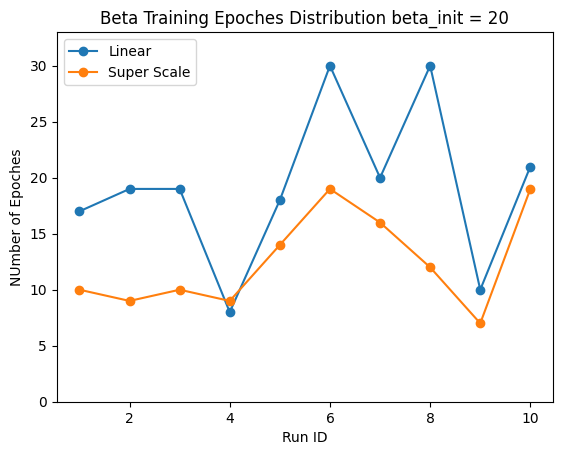

In [81]:
X = np.linspace(1, len(method_1_epoches_list_20),len(method_1_epoches_list_20))
plt.plot(X, method_1_epoches_list_20, label='Linear', marker='o')
plt.plot(X, method_s_epoches_list_20, label='Super Scale', marker='o')
plt.legend(loc='upper left')
plt.title(f'Beta Training Epoches Distribution beta_init = 20')
plt.ylim(0, 33)
plt.xlabel('Run ID')
plt.ylabel('NUmber of Epoches')
plt.show()

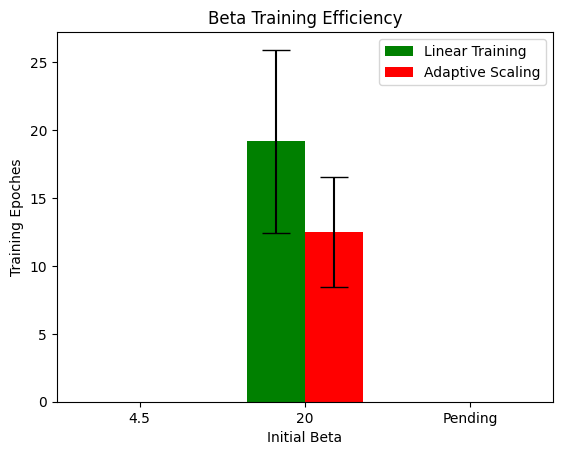

In [87]:
# 假设这是你的两个列表
list1 = method_1_epoches_list_20
list2 = method_s_epoches_list_20

# 计算每个列表的均值和标准差
mean1, std1 = np.mean(list1), np.std(list1)
mean2, std2 = np.mean(list2), np.std(list2)


# 绘制柱状图
labels = ['4.5','20','Pending']
# means = [mean1, mean2]
# stds = [std1, std2]

x = np.arange(len(labels))  # 标签位置
width = 0.35  # 柱子宽度

fig, ax = plt.subplots()
# rects = ax.bar(x, means, width, yerr=std1, capsize=10, label='Mean')
rects200 = ax.bar(x[1] - width/2, mean1, width, yerr=std1, capsize=10, 
                label='Linear Training', color='green')
rects201 = ax.bar(x[1] + width/2, mean2, width, yerr=std2, capsize=10, 
                label='Adaptive Scaling', color='red')
# 添加一些文本标签
ax.set_xlim(-0.5, 2.5)
ax.set_ylabel('Training Epoches')
ax.set_xlabel('Initial Beta')
ax.set_title('Beta Training Efficiency')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [11]:
energy_losses_set1 = [
    6.771340370178223, 5.544289588928223, 5.201516151428223, 
    7.882668495178223, 3.8514184951782227, 5.322121620178223, 
    0.6692895889282227
]

energy_losses_set2 = [
    59.89790678024292, 3.43159818649292, 1.64017915725708, 
    3.02925443649292, 1.31596040725708, 7.20023775100708, 
    2.48295259475708, 3.74556303024292, 4.25443696975708, 
    0.6753354072570801
]

energy_losses_set3 = [
    6.386257171630859, 6.396999359130859, 6.290065765380859, 
    3.5156517028808594, 2.2886009216308594, 2.4555931091308594, 
    1.8393821716308594, 1.7109642028808594, 2.9077415466308594, 
    2.4975852966308594, 2.7280540466308594, 2.1997337341308594, 
    1.3354759216308594, 0.12844467163085938
]

energy_losses_set4 = [
    51.91970682144165, 9.11056661605835, 3.7971482276916504, 
    2.5343947410583496, 2.0802931785583496, 1.6208786964416504, 
    2.4806838035583496, 5.09255838394165, 1.6471877098083496, 
    0.005586147308349609
]

energy_losses_set5 = [
    6.9886369705200195, 1.6590471267700195, 4.9671525955200195, 
    3.0560197830200195, 7.1722307205200195, 6.0389299392700195, 
    2.1009416580200195, 1.3411760330200195, 2.7669572830200195, 
    0.29820728302001953
]

energy_losses_set6 = [
    3.6980690956115723, 1.7014870643615723, 1.2189230918884277, 
    0.46467065811157227
]

energy_losses_set7 = [
    2.892119884490967, 2.546416759490967, 6.163115978240967, 
    5.540069103240967, 3.783233165740967, 1.7832331657409668, 
    0.1464543342590332
]

energy_losses_set8 = [
    2.568500518798828, 3.054828643798828, 2.986186981201172, 
    2.545551300048828, 2.741352081298828, 1.5328559875488281, 
    5.406108856201172, 7.449359893798828, 3.724468231201172, 
    2.003070831298828, 0.7726020812988281
]

energy_losses_set9 = [
    3.172390937805176, 3.296902656555176, 5.471707344055176, 
    5.130398750305176, 2.351590156555176, 2.672879219055176, 
    2.160183906555176, 4.007840156555176, 3.361844062805176, 
    1.7461214065551758, 0.014620780944824219
]

energy_losses_set10 = [
    5.179715156555176, 1.9570035934448242, 4.403347969055176, 
    2.730008125305176, 4.478487968444824, 3.813504219055176, 
    1.5575895309448242, 1.8867464065551758, 1.4731168746948242, 
    0.12106609344482422
]

energy_losses_set11 = [
    4.461341381072998, 5.683021068572998, 4.195716381072998, 
    3.790931224822998, 5.603431224822998, 2.050208568572998, 
    1.350013256072998, 2.119056224822998, 2.951575756072998, 
    1.606041431427002, 2.049720287322998, 0.20662736892700195
]

energy_losses_set12 = [
    4.54022216796875, 2.97637939453125, 3.93377685546875, 
    0.34881591796875
]

energy_losses_set13 = [
    2.7013068199157715, 4.6671271324157715, 4.7247443199157715, 
    4.9766974449157715, 4.6134161949157715, 1.3184943199157715, 
    2.5684943199157715, 3.8853888511657715, 0.17418146133422852
]

energy_losses_set14 = [
    3.55464506149292, 1.67427396774292, 1.26078462600708, 
    2.19331693649292, 18.35689115524292, 6.84175443649292, 
    1.13578462600708, 3.61812162399292, 6.83540678024292, 
    10.74222993850708, 2.85160493850708, 0.8266177177429199
]

energy_losses_set15 = [
    6.157957077026367, 7.271238327026367, 5.704343795776367, 
    5.155027389526367, 4.181394577026367, 2.369871139526367, 
    0.1745586395263672
]

energy_losses_set16 = [
    4.9111456871032715, 1.4433465003967285, 2.7773566246032715, 
    1.4663214683532715, 1.2929558753967285, 1.7753777503967285, 
    3.9550909996032715, 1.3974480628967285, 0.7558722496032715
]

energy_losses_set17 = [
    2.269911289215088, 2.658094882965088, 4.847059726715088, 
    6.655653476715088, 2.190809726715088, 2.387098789215088, 
    1.417372226715088, 0.6419816017150879
]

energy_losses_set18 = [
    2.7012414932250977, 0.13420772552490234
]

energy_losses_set19 = [
    1.3468360900878906, 3.0187110900878906, 6.701816558837891, 
    2.4947853088378906, 3.2447853088378906, 3.9889259338378906, 
    3.0650978088378906, 1.2399024963378906, 4.347324371337891, 
    5.260410308837891, 0.9493751525878906, 0.6258201599121094
]

energy_losses_set20 = [
    4.783688068389893, 1.7553744316101074, 2.5776333808898926, 
    0.8808560371398926
]

epoch_list_1 =[]
epoch_list_s =[]
for i in range(1, 11):
    # Dynamically access the energy loss set
    energy_loss_set_1 = globals()[f'energy_losses_set{2*i-1}']
    energy_loss_set_s = globals()[f'energy_losses_set{2*i}']
    epoch_list_1.append(len(energy_loss_set_1))
    epoch_list_s.append(len(energy_loss_set_s))



In [12]:
epoch_list_1

[7, 14, 10, 7, 11, 12, 9, 7, 8, 12]

In [13]:
epoch_list_s

[10, 10, 4, 11, 10, 4, 12, 9, 2, 4]

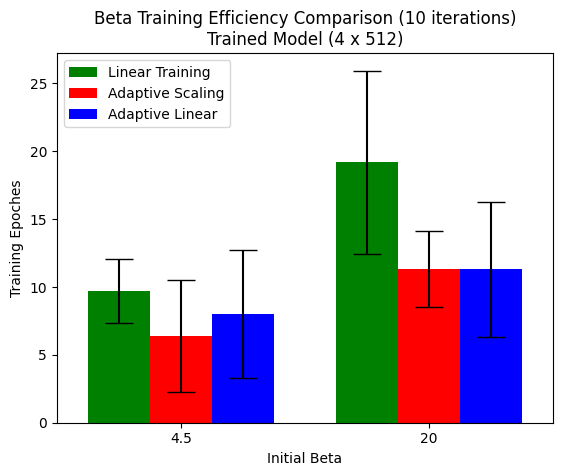

In [19]:
# result for beta_init = 20, linear and scaling method.
list_l_20 = [17, 19, 19, 8, 18, 30, 20, 30, 10, 21]
# list_as_20 = [10, 9, 10, 9, 14, 19, 16, 12, 7, 19] #It is a wrong way
list_al_20 = [12, 8, 7, 23, 6, 16, 14, 7, 10, 10]
list_as_20 = [9, 14, 10, 9, 16, 16, 10, 11, 8, 10]
# result for beta_init = 4.5, linear and scaling method.
list_l_45 = [7, 14, 10, 7, 11, 12, 9, 7, 8, 12]
# list_as_45 = [10, 10, 4, 11, 10, 4, 12, 9, 2, 4] #It is a wrong way
list_as_45 = [2, 11, 2, 4, 9, 9, 4, 5, 3, 15]
list_al_45 = [12, 6, 3, 13, 7, 5, 18, 3, 4, 9]

mean1, std1 = np.mean(list_l_20), np.std(list_l_20)
mean2, std2 = np.mean(list_as_20), np.std(list_as_20)
mean3, std3 = np.mean(list_al_20), np.std(list_al_20)
mean4, std4 = np.mean(list_l_45), np.std(list_l_45)
mean5, std5 = np.mean(list_as_45), np.std(list_as_45)
mean6, std6 = np.mean(list_al_45), np.std(list_al_45)

labels = ['4.5','20']

x = np.arange(len(labels)) 
width = 0.25

fig, ax = plt.subplots()

rects200 = ax.bar(x[1] - width, mean1, width, yerr=std1, capsize=10, 
                label='Linear Training', color='green')
rects201 = ax.bar(x[1], mean2, width, yerr=std2, capsize=10, 
                label='Adaptive Scaling', color='red')
rects202 = ax.bar(x[1] + width, mean3, width, yerr=std3, capsize=10, 
                label='Adaptive Linear', color='blue')

rects450 = ax.bar(x[0] - width, mean4, width, yerr=std4, capsize=10, 
                label='Linear Training', color='green')
rects451 = ax.bar(x[0], mean5, width, yerr=std5, capsize=10,
                label='Adaptive Scaling', color='red')
rects452 = ax.bar(x[0] + width, mean6, width, yerr=std6, capsize=10,
                label='Adaptive Linear', color='blue')
handles, data_labels = ax.get_legend_handles_labels()
by_label = dict(zip(data_labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')


ax.set_xlim(-0.5, 1.5)
ax.set_ylabel('Training Epoches')
ax.set_xlabel('Initial Beta')
ax.set_title('Beta Training Efficiency Comparison (10 iterations)\nTrained Model (4 x 512)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.savefig('Beta Training Efficiency.png', dpi = 300)
plt.show()

<Figure size 640x480 with 0 Axes>

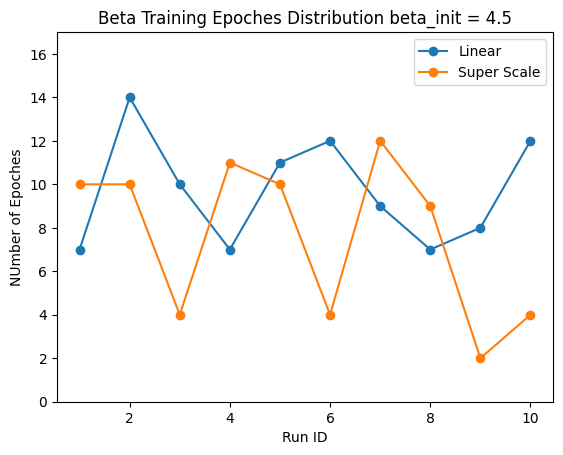

In [35]:
X = np.linspace(1, len(list3),len(list3))
plt.plot(X, list3, label='Linear', marker='o')
plt.plot(X, list4, label='Super Scale', marker='o')
plt.legend(loc='best')
plt.title(f'Beta Training Epoches Distribution beta_init = 4.5')
plt.ylim(0, 17)
plt.xlabel('Run ID')
plt.ylabel('NUmber of Epoches')
plt.show()